## 05.29

- definir API para realizar un experimento
    # En un experimento se puede configurar
    # - el grafo del sistema
    # - la funcion de como actualizan los agentes su precio
    # - el numero de pasos de la simulacion
    # - las metricas para evaluar sobre el grafo en cada paso

#### To Do

- [ ] Integrar la funcion de update
- [ ] Definir como integrar sobre que nodos iterar en cada step
- [ ] Definir metodo para guardar los resultados del experimento

In [83]:
# mantener los imports siempre arriba
from networkx import DiGraph
from networkx.drawing import draw

# import sys # Para subir el límite de recursión. (No lo usamos mas)
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import itertools as it
import pandas as pd
import queue

In [84]:
# Precondiciones:
# dinamica: 1, 2, 3.
# 0 <= alpha <= 1.
class Experimento:
  def __init__(self, grafo, dinamica, duracion_periodo = 10, metricas=None, inflacion=None, alpha = 0.5): # Función de update es la dinámica, puede ser 1 2 o 3. El aplha es CUANTO ve la inflación. Alpha == 1 es lo mismo que la dinamica 2. Alpha == 0 es lo mismo que la dinamica 1.
    self.grafo = grafo.copy()
    self.dinamica = dinamica
    self.metricas = metricas or {}
    self._curr_step = 0
    self._metricas_evaluadas = {nombre:[] for nombre in self.metricas}
    self.queue = queue.Queue() #Fila de tuplas (Nodo, aumento)
    self.duracion_periodo = duracion_periodo
    self.precios_periodo_pasado = {}
    for nodo in self.grafo.nodes:
      self.precios_periodo_pasado[nodo] = self.grafo.nodes[nodo]['precio']

    self.inflacion = inflacion or 0 # Expresada en %.
    self.alpha = alpha

  def shock(self, nodo, aumento):
    precio_actual = self.grafo.nodes[nodo]['precio']
    nuevo_precio = { nodo : { 'precio': (precio_actual * (1 + (aumento/100)))}}
    nx.set_node_attributes(self.grafo, nuevo_precio)
    vecinos = self.grafo[nodo].items()
    aumentos_a_pasar = []
    for vecino in vecinos:
      aumento_vecino = self.actualizar(vecino,aumento)
      aumentos_a_pasar.append(aumento_vecino)
    for i, vecino in enumerate(vecinos):
      self.queue.put((vecino[0], aumentos_a_pasar[i]))

  def step(self, n=1): # aumento pasado en %.
    for _ in range(n):
        self._single_step()
        self._calcular_metricas()
        self._curr_step += 1

  def actualizar(self, vecino, aumento):
    nodo_vecino = vecino[0]
    precio_actual = self.grafo.nodes[nodo_vecino]['precio']
    peso_arista = vecino[1][0]['w']
    if self.dinamica == 1:
      aumento_vecino = aumento * peso_arista
    if self.dinamica == 2:
      aumento_vecino = aumento * (1 + self.inflacion/100)
    if self.dinamica == 3:
      aumento_vecino = (self.alpha * self.inflacion) + ((1 -self.alpha) * (aumento * peso_arista))
    nuevo_precio = {nodo_vecino : {'precio':  (precio_actual * (1 + (aumento_vecino / 100)))}}
    nx.set_node_attributes(self.grafo, nuevo_precio)
    return aumento_vecino

  def _single_step(self):
    if self._curr_step % self.duracion_periodo == 0:
      self.actualizar_inflacion()

    if not self.queue.empty():
      nodo_actual, aumento = self.queue.get()
      vecinos = self.grafo[nodo_actual].items()
      aumentos_a_pasar = []
      for vecino in vecinos:
        aumento_vecino = self.actualizar(vecino,aumento) #Side effect actualiza ese vecino.
        aumentos_a_pasar.append(aumento_vecino)
      for i, vecino in enumerate(vecinos):
        self.queue.put((vecino[0], aumentos_a_pasar[i]))

  def actualizar_inflacion(self): # Asumimos una inflación no ponderada
    # donde la "canasta" sea un producto de cada sector. Entonces,
    # la canasata es la sumatoria de los precios de todos los sectores, y con eso calculamos IPC e inflación.
    # calculo los precios actuales
      precios_periodo_actual = {}
      for nodo in self.grafo.nodes:
        precios_periodo_actual[nodo] = self.grafo.nodes[nodo]['precio']
      ipc_actual = sum(precios_periodo_actual.values()) / len(precios_periodo_actual)
      ipc_pasado = sum(self.precios_periodo_pasado.values()) / len(self.precios_periodo_pasado)
      self.precios_periodo_pasado = precios_periodo_actual.copy()
      self.inflacion = ((ipc_actual / ipc_pasado) - 1)  * 100

  def _calcular_metricas(self):
    for nombre, metrica in self.metricas.items():
          self._metricas_evaluadas[nombre].append(metrica(self.grafo))

  def plot(self, labels=True, grande=False, node_data=True,):
    connectionstyle = [f"arc3,rad={r}" for r in it.accumulate([0.15] * 4)]
    tamaños = list(self.grafo.degree())
    for i in range(len(tamaños)):
      tamaños[i] = (tamaños[i][1] ** 2) / 9 if ((tamaños[i][1] ** 2) / 9 ) > 100 else 100
    pos = nx.kamada_kawai_layout(self.grafo)
    if grande:
      fig, ax = plt.subplots(figsize=(30, 30))
    else:
      fig,ax = plt.subplots(figsize=(8,8))
    plt.axis("off")
    nx.draw_networkx_nodes(self.grafo, pos, node_size=tamaños, ax = ax)
    nx.draw_networkx_labels(self.grafo, pos, font_size=10, ax=ax)
    nx.draw_networkx_edges(
        self.grafo, pos, edge_color="grey", connectionstyle=connectionstyle, ax=ax, arrows=True, arrowstyle='->',
    )
    if labels:
      labels = {
          tuple(edge): f"{'w'}={round(attrs['w'],3)}"
          for *edge, attrs in self.grafo.edges(keys=True, data=True)
      }
      nx.draw_networkx_edge_labels(
          self.grafo,
          pos,
          labels,
          connectionstyle=connectionstyle,
          label_pos=0.3,
          font_color="blue",
          bbox={"alpha": 0},
          ax=ax,
      )
      labels = dict(self.grafo.nodes(data=True))
      for key in labels:
        labels[key] = labels[key]['precio']
      for key in pos:
        pos[key] = pos[key] + 0.05
      nx.draw_networkx_labels(
          self.grafo,
          pos,
          labels,
          font_size = 10,
          font_color="red",
          ax=ax,
      )

  def __str__(self):
      return str(self.to_dict())

  def __repr__(self):
      return str(self)

  def to_dict(self):
      return {"id_grafo": hash(self.grafo), "step": self._curr_step, "metricas": self._metricas_evaluadas}

In [85]:
def armar_grafo(dataframe, precios_random=True):
  graph = {}
  for index, row in dataframe.iterrows():
    d = {}
    for (k, v) in row.items():
      d[k] = {"w":v}
    graph[index] = d
  G_base = nx.MultiDiGraph(graph)
  G = nx.MultiDiGraph(graph)
  for (n1,n2,d) in G_base.edges(data=True):
    if d['w'] == 0:
      G.remove_edge(n1,n2)

  nodos = list(G.nodes())
  precios = {}
  for nodo in nodos:
    if precios_random:
      precios[nodo] = {'precio': int(round(np.random.rand() * 1000, 0))}
    else:
      precios[nodo] = {'precio': 100}
  nx.set_node_attributes(G, precios)
  return G

In [86]:
sectores = ['luz','chapa','campo','chip','comida']

pesos = np.array([[0,0.25,0.1,0,0],[0,0,0,0.7,0.15],[0,0,0,0,0.8],[0,0,0,0,0],[0,0,0,0,0]])
test = pd.DataFrame(data=pesos,columns=sectores,index=sectores)

pesos_ciclo = np.array([[0,0.25,0.1,0,0],[0,0,0,0.7,0.15],[0,0,0,0,0.8],[0.2,0,0,0,0],[0,0,0,0,0]])
test_ciclo = pd.DataFrame(data=pesos_ciclo,columns=sectores,index=sectores)
g_test = armar_grafo(test, precios_random=False)
g_test_ciclo = armar_grafo(test_ciclo, precios_random=False)

In [87]:
exp1 = Experimento(g_test,1)

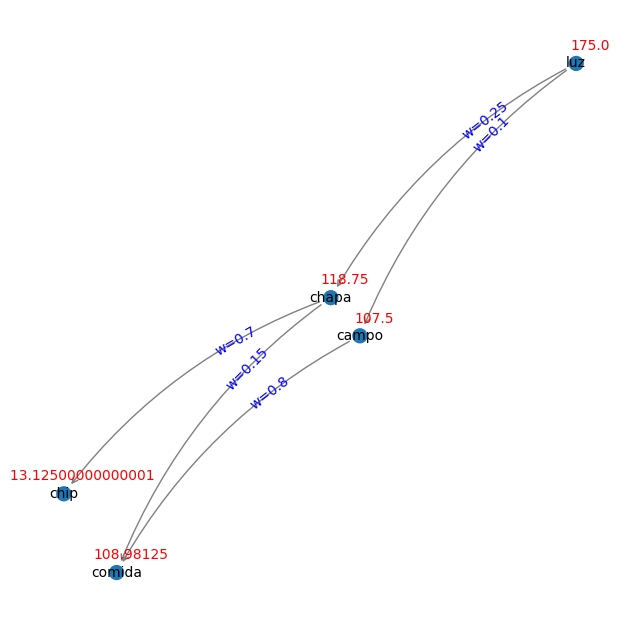

In [88]:
exp1.shock('luz',75)
exp1.step(20)
exp1.plot()

In [89]:
exp_alpha_1 = Experimento(g_test,1, alpha = 0)
exp_alpha_2 = Experimento(g_test,3, alpha = 0)

Con el alpha en 0, la dinámica 3 es igual a la 1. Lo vemos:

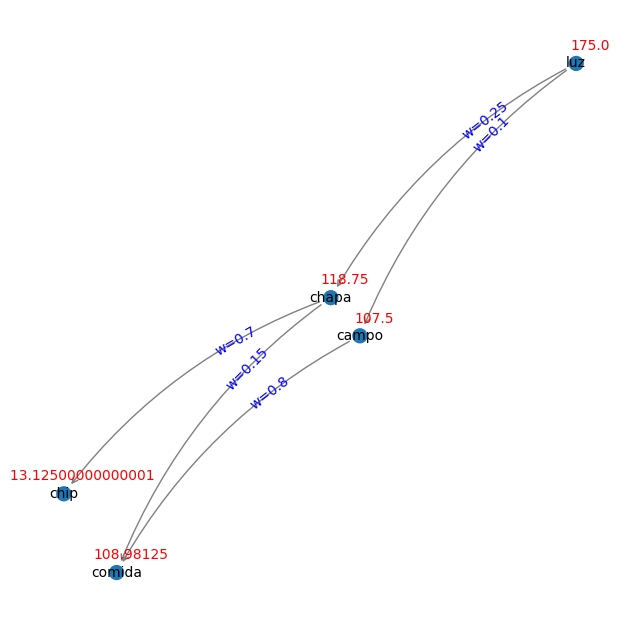

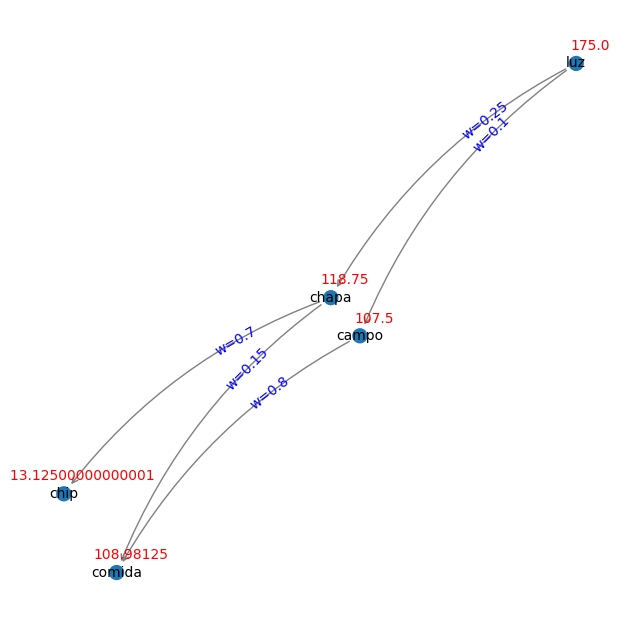

In [90]:
exp_alpha_1.shock('luz',75)
exp_alpha_2.shock('luz',75)
exp_alpha_1.step(20)
exp_alpha_2.step(20)
exp_alpha_1.plot()
exp_alpha_2.plot()

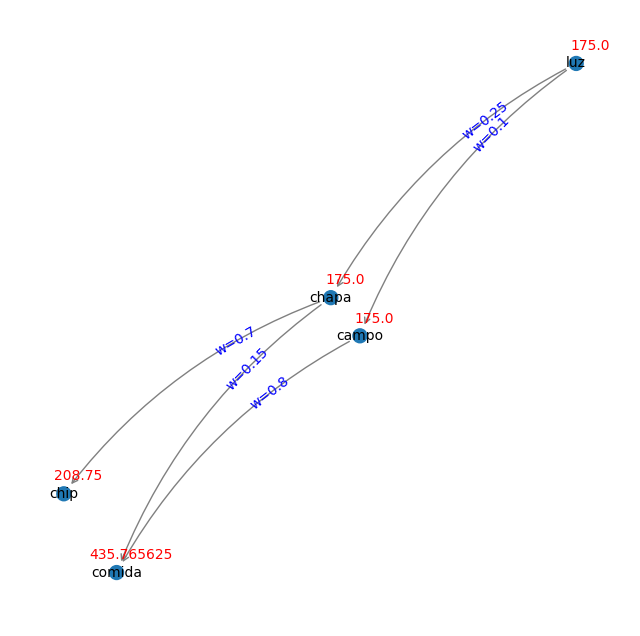

In [91]:
exp1_2 = Experimento(g_test,2)
exp1_2.shock('luz',75)
exp1_2.step(20)
exp1_2.plot()

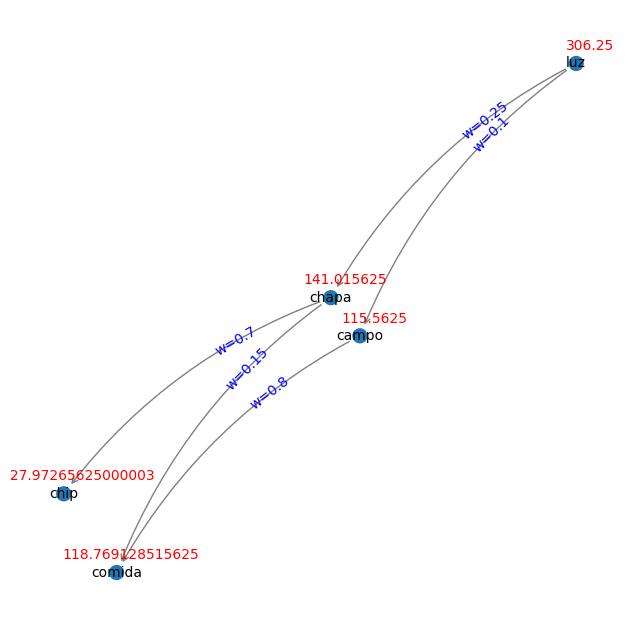

In [92]:
exp1.shock('luz',75)
exp1.step(50)
exp1.plot()

Inflación actual  20.24999999999999
Inflación actual  4.78711325225929
Inflación actual  0.011994790017455514
Inflación actual  4.659815824314961e-05
Inflación actual  2.6143003317713465e-07


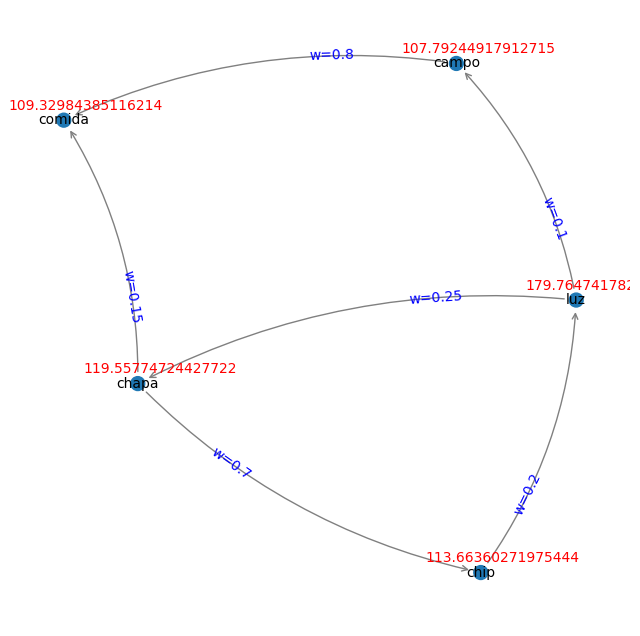

In [ ]:
exp2 = Experimento(g_test_ciclo,1)
exp2.shock('luz',75)
exp2.step(50)
exp2.plot()

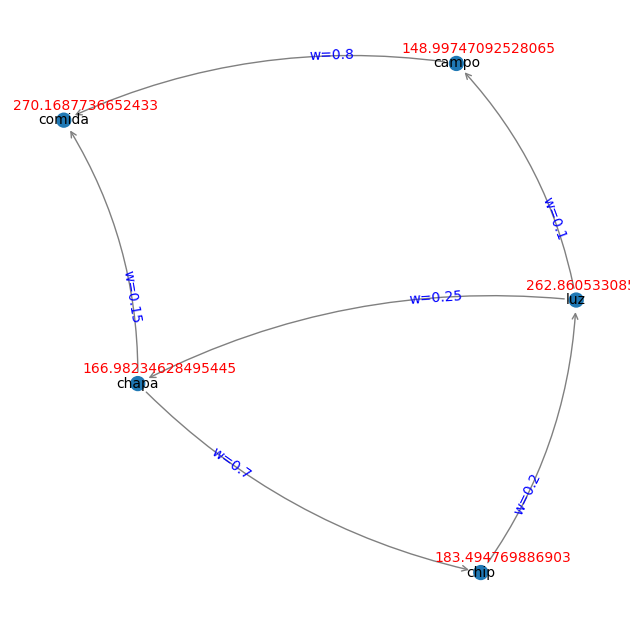

In [99]:
exp2 = Experimento(g_test_ciclo,3,alpha=0.3)
exp2.shock('luz',75)
exp2.step(50)
exp2.plot()